In [1]:
from numba import njit
import sklearn
import pandas as pd
from pandas.core.interchange.dataframe_protocol import DataFrame
import numpy as np
import scipy.optimize._minimize as minimize

In [2]:
def get_prob(A, x_i, x_j, pi, sigma_i, knn):
    if x_j in knn[x_i]:
        return np.exp(-(np.linalg.norm(A[x_i] - A[x_j])-pi)/sigma_i)
    return 0

In [3]:
def bin_search(arr, goal, epsilon):
    start, end = 0,len(arr)-1
    for i in range(end+1):
        middle = int((end - start)/2)
        if goal-epsilon <= arr[middle] <= goal+epsilon:
            return middle
        elif arr[middle] < goal-epsilon:
            start = middle+1
        else:
            end = middle-1
    return -1

In [4]:
def find_sigma_i(x_i, pi: float, k: int, Neighbours, A: np.ndarray):
    sig_i = np.linspace(0, 10, 100)
    goal = np.log2(k)
    def sig_exp(x_i, pi, sig, Neighbours, A):
        res = 0
        for x_ij in Neighbours:
            res += np.exp(-(np.linalg.norm(A[x_i]-A[x_ij])-pi)/sig)
        return res
    sigs = sig_exp(x_i, pi, sig_i, Neighbours, A)
    sig = bin_search(sigs, goal, 0.01)
    return sig_i[sig]
    

In [5]:
import numpy as np

def construct_knn(A: np.ndarray, k):
    """
    Constructs a k-NN matrix with distances.

    Parameters:
    - A (np.ndarray): Input data of shape (n_samples, n_features).
    - k (int): Number of nearest neighbors to find.

    Returns:
    - knn_indices (np.ndarray): k-NN indices matrix of shape (n_samples, k).
    - knn_dist_min (np.ndarray): Minimum nonzero distance for each sample.
    """
    n_samples = A.shape[0]
    knn_indices = np.zeros((n_samples, k), dtype=int)
    knn_dist_min = np.zeros((n_samples, 1), dtype=float)  # Should store float distances

    for i in range(n_samples):
        # Compute Euclidean distances
        distances = np.linalg.norm(A - A[i], axis=1)
        # Sort indices by distance, excluding the first (self)
        sorted_indices = np.argsort(distances)
        knn_indices[i] = sorted_indices[1:k+1]  # Skip self (index 0)
        knn_dist_min[i] = np.min(distances[sorted_indices[1:]])  # Min nonzero distance
    knn_map = {}
    knn_dist_map = {}
    for i in range(n_samples):
        knn_map[i] = set(knn_indices[i])
        knn_dist_map[i] = knn_dist_min[i]
    return knn_map, knn_indices, knn_dist_map


In [6]:
#input in as a pandas dataframe
def umap(data: pd.DataFrame, k: int, a,b):
    p_ij = {}
    data = data.copy().to_numpy()
    n_samples = data.shape[0]
    knn_map, knn_mat, knn_dist = construct_knn(data, k)
    for i in range(n_samples):
        for j in range(n_samples):
            if j == i:
                continue
            pi = knn_dist[i]
            sig = find_sigma_i(i, pi, k, knn_map[i], data)
            p_ij[(i,j)] = get_prob(data, i, j, pi, sig, knn_map)
    symmetric_knn_matrix = np.maximum(knn_mat, knn_mat.T)
    _, D = knn_mat.diagonalize()
    L = D - symmetric_knn_matrix
    return L

In [7]:
df = pd.read_csv("diabetes.csv")
data = pd.DataFrame({
    'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17],
    'B': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17 ],
    'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17],
})

nn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
print()

In [8]:
import numpy as np
from collections import Counter

In [9]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
# expr = pd.read_csv(path + 'bartoschek_filtered_expr_rpkm.txt', sep='\t')
# print(expr.iloc[0:4,0:4])
# X_train = expr.values[:,0:(expr.shape[1]-1)]
# X_train = np.log(X_train + 1)
# n = X_train.shape[0]
# print("\nThis data set contains " + str(n) + " samples")
# y_train = expr.values[:,expr.shape[1]-1]
# print("\nDimensions of the  data set: ")
# print(X_train.shape, y_train.shape)

In [57]:
expr = pd.read_csv("diabetes.csv")
diabetic = expr[expr['Outcome'] == 1]
diabetic =diabetic.drop(['Outcome'], axis=1)
diabetic_x = diabetic.values[:, 0:(diabetic.shape[1] - 1)]
diabetic_x = np.log(diabetic_x + 1)
n = diabetic_x.shape[0]
print("\nThis data set contains " + str(n) + " samples")


This data set contains 268 samples


In [58]:
diabetic_y = diabetic.values[:, diabetic.shape[1] - 1]
print("\nDimensions of the  data set: ")
print(diabetic.shape, diabetic_y.shape)


Dimensions of the  data set: 
(268, 8) (268,)


In [61]:
non_diabetic = expr[expr['Outcome']==0]
non_diabetic =non_diabetic.drop(['Outcome'], axis=1)
non_diabetic_x = non_diabetic.values[:,0:(non_diabetic.shape[1]-1)]
non_diabetic_x = np.log(non_diabetic + 1)
non = non_diabetic_x.shape[0]
print("\nThis data set contains " + str(non) + " samples")
non_diabetic_y = non_diabetic.values[:,non_diabetic.shape[1]-1]
print("\nDimensions of the  data set: ")
print(non_diabetic_x.shape, non_diabetic_y.shape)


This data set contains 500 samples

Dimensions of the  data set: 
(500, 8) (500,)


In [60]:
dist_diabetes = np.square(euclidean_distances(diabetic_x, diabetic_x))
dist_non_diabetes = np.square(euclidean_distances(non_diabetic_x, non_diabetic_x))
dist_non_diabetes[0:4, 0:4]

array([[ 0.        , 20.95428609, 12.89879364, 32.35319618],
       [20.95428609,  0.        , 32.2528324 , 51.63372662],
       [12.89879364, 32.2528324 ,  0.        , 19.10921109],
       [32.35319618, 51.63372662, 19.10921109,  0.        ]])

In [62]:
def prob_high_dim(sigma, dist_row, dist):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimensions (1D array)
    """
    exp_distance = np.exp(-dist[dist_row] / (2*sigma**2))
    exp_distance[dist_row] = 0
    prob_not_symmetr = exp_distance / np.sum(exp_distance)
    #prob_symmetr = (prob_not_symmetr + prob_not_symmetr.T) / (2*n_samples)
    return prob_not_symmetr

def perplexity(prob):
    """
    Compute perplexity (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, -np.sum([p*np.log2(p) for p in prob if p!=0]))

In [63]:
def sigma_binary_search(perp_of_sigma, fixed_perplexity):
    """
    Solve equation perp_of_sigma(sigma) = fixed_perplexity 
    with respect to sigma by the binary search algorithm
    """
    sigma_lower_limit = 0
    sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if perp_of_sigma(approx_sigma) < fixed_perplexity:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_perplexity - perp_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

In [64]:
PERPLEXITY = 30
prob_diabetes = np.zeros((n,n))
sigma_array_diabetic = []
for dist_row in range(n):
    func_diabetes = lambda sigma: perplexity(prob_high_dim(sigma, dist_row, dist_diabetes))
    binary_search_result = sigma_binary_search(func_diabetes, PERPLEXITY)
    prob_diabetes[dist_row] = prob_high_dim(binary_search_result, dist_row, dist_diabetes)
    sigma_array_diabetic.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(np.mean(sigma_array_diabetic)))

Sigma binary search finished 100 of 268 cells
Sigma binary search finished 200 of 268 cells

Mean sigma = 0.5001737110650362


In [ ]:
prob_non_diabetes = np.zeros((n,n))
sigma_array_non_diabetic = []
PERPLEXITY = 30
prob_diabetes = np.zeros((n, n))
sigma_array_diabetic = []
for dist_row in range(n):
    func_diabetes = lambda sigma: perplexity(prob_high_dim(sigma, dist_row, dist_diabetes))
    binary_search_result = sigma_binary_search(func_diabetes, PERPLEXITY)
    prob_diabetes[dist_row] = prob_high_dim(binary_search_result, dist_row, dist_diabetes)
    sigma_array_diabetic.append(binary_search_result)
    func_non_diabetes = lambda sigma: perplexity(prob_high_dim(sigma, dist_row, dist_diabetes))
    binary_search_result = sigma_binary_search(func_diabetes, PERPLEXITY)
    prob_diabetes[dist_row] = prob_high_dim(binary_search_result, dist_row, dist_diabetes)
    sigma_array_diabetic.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(np.mean(sigma_array_diabetic)))

In [65]:
P = prob_diabetes + np.transpose(prob_diabetes)
P

array([[0.00000000e+00, 1.51264568e-14, 5.72653436e-27, ...,
        1.74933486e-14, 8.26979993e-02, 1.34053151e-15],
       [1.51264568e-14, 0.00000000e+00, 9.95417834e-39, ...,
        1.68515419e-02, 2.92651251e-10, 4.39650758e-04],
       [5.72653436e-27, 9.95417834e-39, 0.00000000e+00, ...,
        2.33387769e-38, 7.26571490e-24, 4.43641128e-35],
       ...,
       [1.74933486e-14, 1.68515419e-02, 2.33387769e-38, ...,
        0.00000000e+00, 4.04066036e-10, 1.58995892e-03],
       [8.26979993e-02, 2.92651251e-10, 7.26571490e-24, ...,
        4.04066036e-10, 0.00000000e+00, 7.08785771e-12],
       [1.34053151e-15, 4.39650758e-04, 4.43641128e-35, ...,
        1.58995892e-03, 7.08785771e-12, 0.00000000e+00]])

In [17]:
def prob_low_dim(Y):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    inv_distances = np.power(1 + np.square(euclidean_distances(Y, Y)), -1)
    np.fill_diagonal(inv_distances, 0.)
    return inv_distances / np.sum(inv_distances, axis = 1, keepdims = True)

In [18]:
def KL(P, Y):
    """
    Compute KL-divergence from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return P * np.log(P + 0.01) - P * np.log(Q + 0.01)

In [19]:
def KL_gradient(P, Y):
    """
    Compute gradient of KL-divergence
    """
    Q = prob_low_dim(Y)
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + np.square(euclidean_distances(Y, Y)), -1)
    return 4*np.sum(np.expand_dims(P - Q, 2) * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

In [28]:
N_LOW_DIMS = 2
LEARNING_RATE = 0.6
MAX_ITER = 200

np.random.seed(12345)
y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))
KL_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * KL_gradient(P, y)
    
    plt.figure(figsize=(20,15))
    plt.scatter(y[:,0], y[:,1], c=y_train.astype(int), cmap = 'tab10', s = 50)
    plt.close()
    KL_array.append(np.sum(KL(P, y)))
    if i % 10 == 0:
        print("KL divergence = " + str(np.sum(KL(P, y))))

Running Gradient Descent: 

KL divergence = 2973.6316962724172
KL divergence = 2593.6226855876616
KL divergence = 2324.050940364389
KL divergence = 2202.7647398331255
KL divergence = 2134.1701535873353
KL divergence = 2088.6331315876782
KL divergence = 2055.867311980483
KL divergence = 2031.223012602361
KL divergence = 2011.8880153474943
KL divergence = 1996.040451325569
KL divergence = 1982.9330104017574
KL divergence = 1971.888090234703
KL divergence = 1962.2066776037636
KL divergence = 1953.7043673398323
KL divergence = 1946.213269816971
KL divergence = 1939.6246181400356
KL divergence = 1933.6648364394716
KL divergence = 1928.2558371960345
KL divergence = 1923.4047196717945
KL divergence = 1918.952583340114


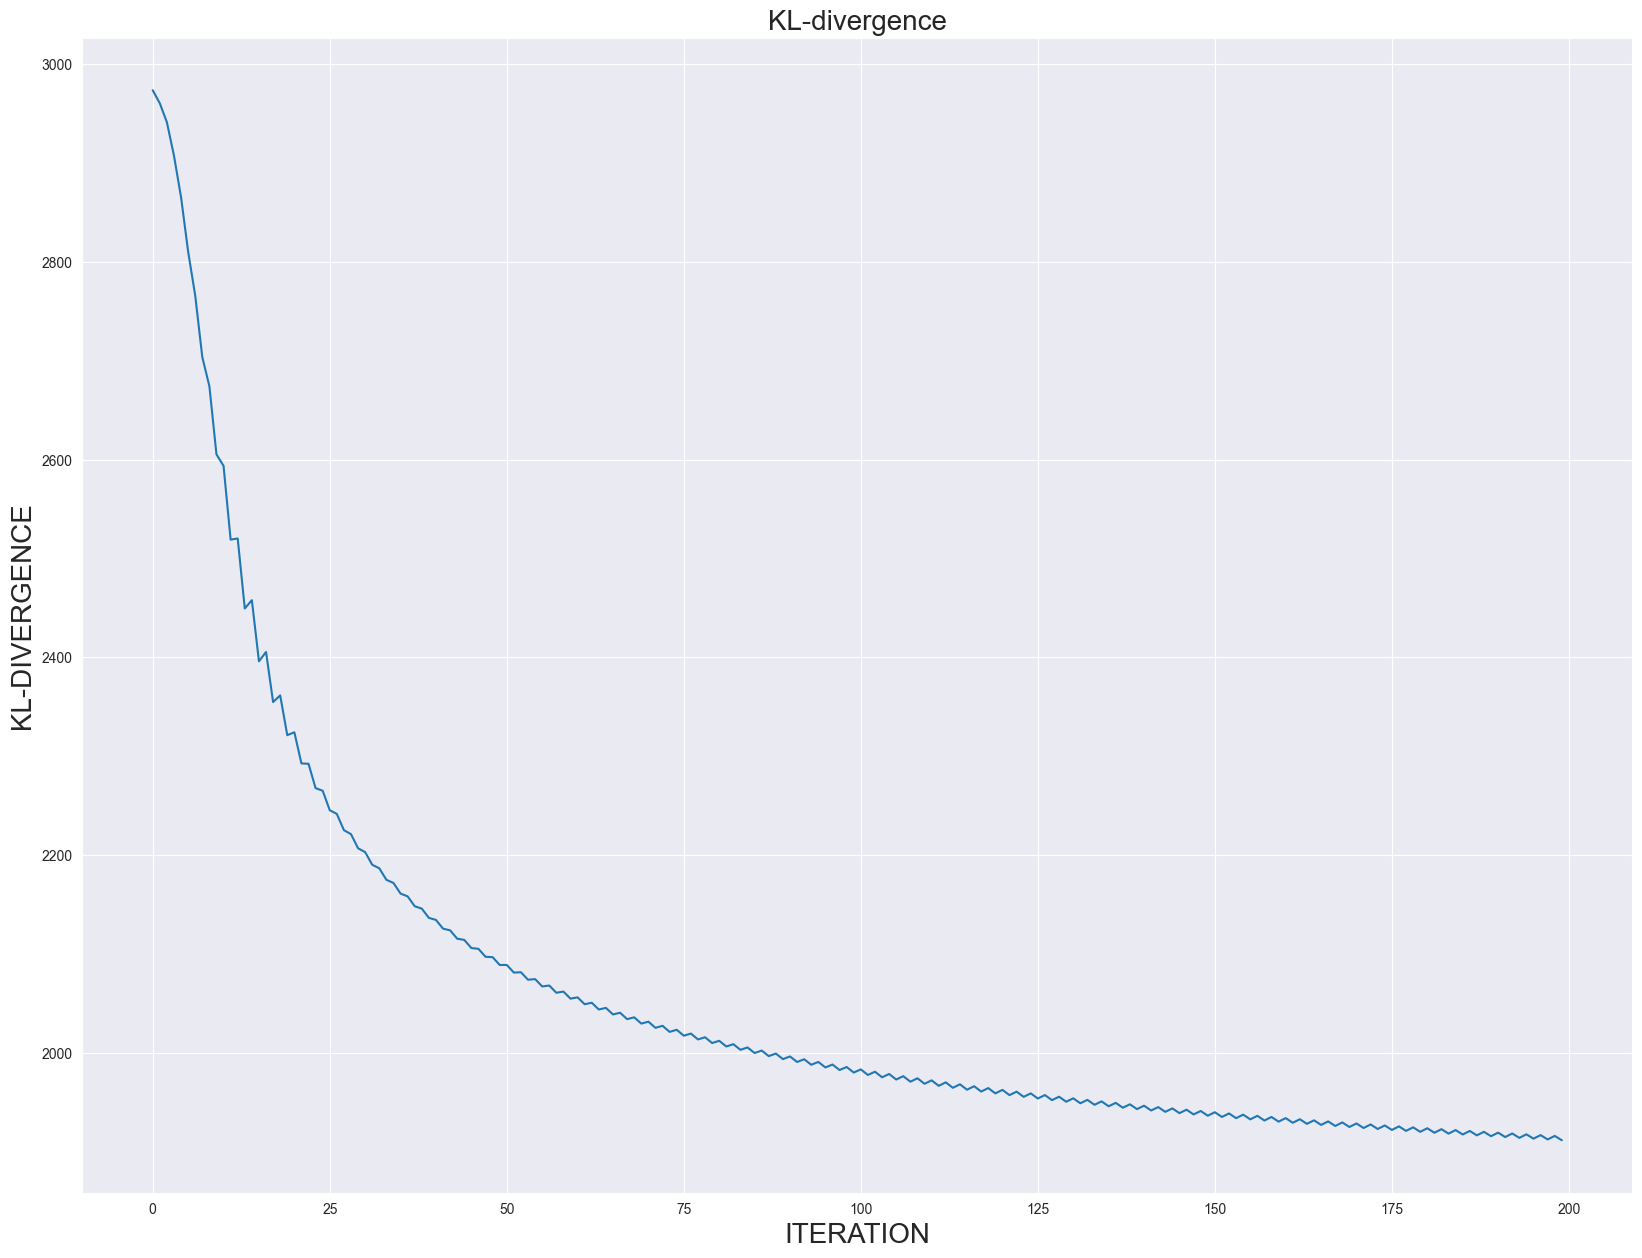

In [29]:
plt.figure(figsize=(20,15))
plt.plot(KL_array)
plt.title("KL-divergence", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("KL-DIVERGENCE", fontsize = 20)
plt.show()

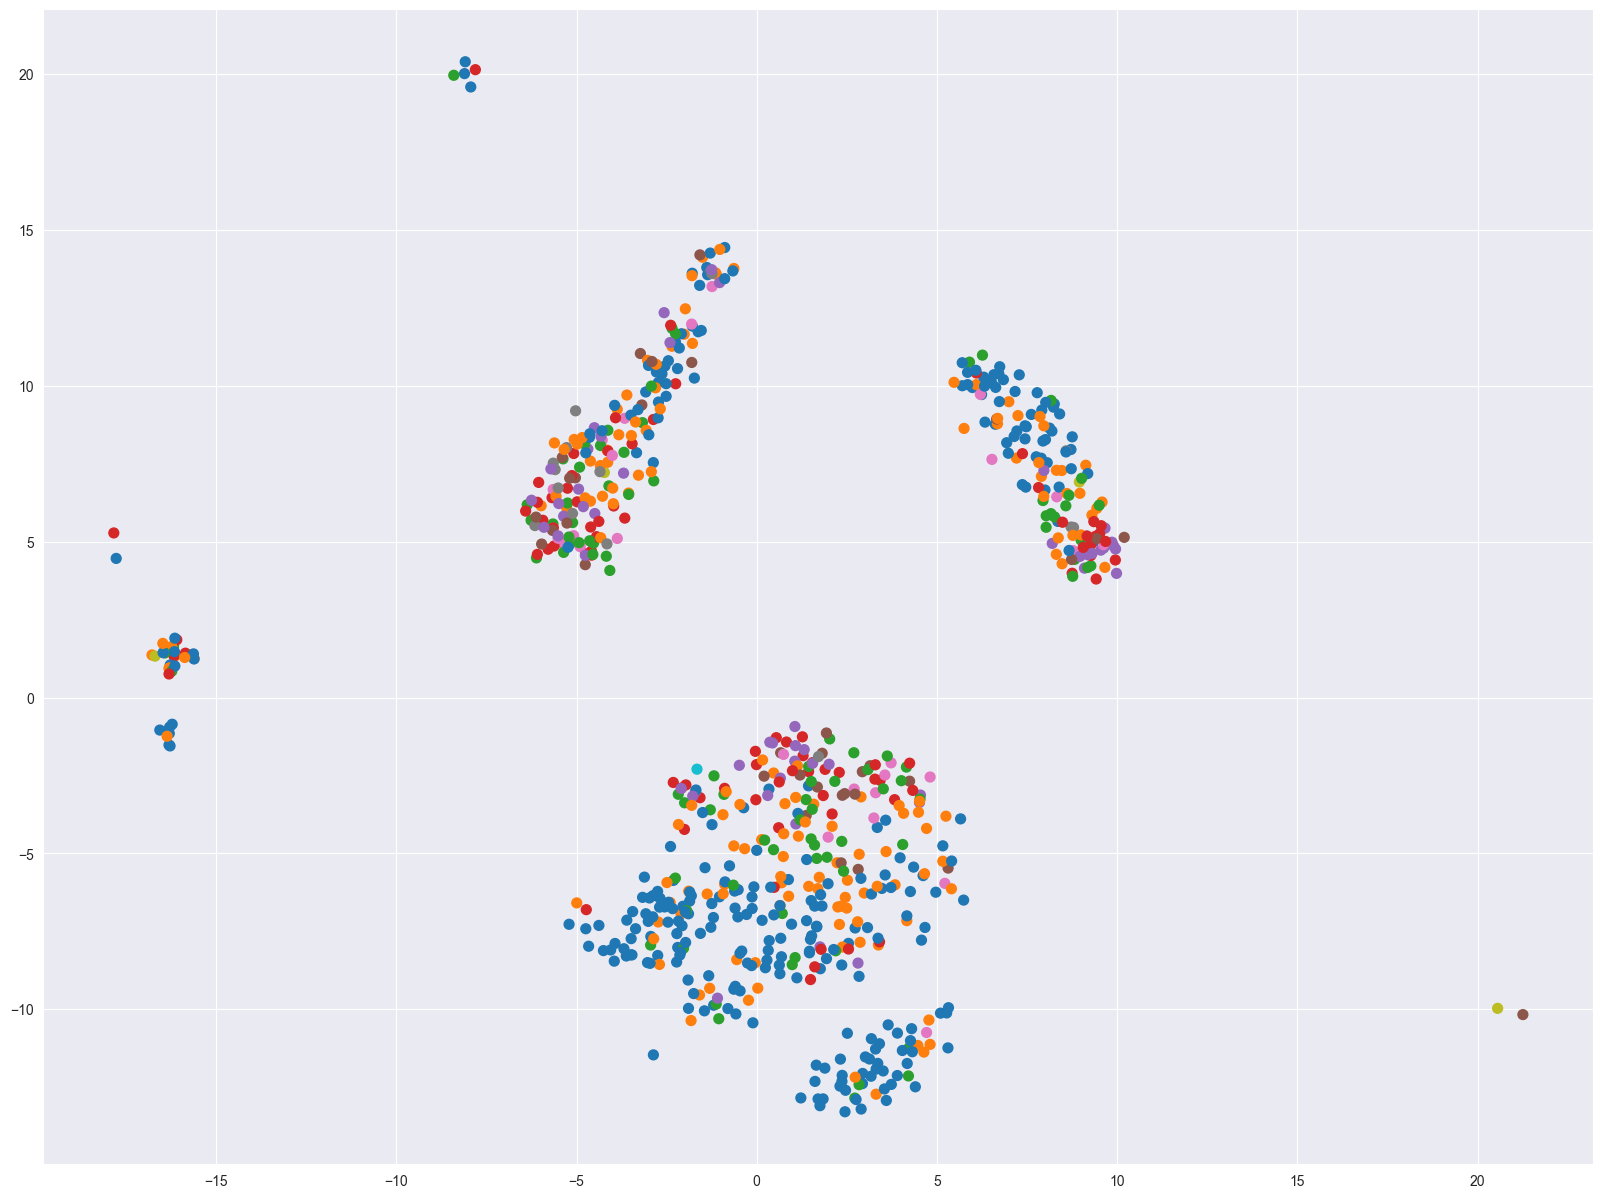

In [32]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c=y_train.astype(int), cmap = 'tab10', s = 50)
plt.show()